Import the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_squared_log_error
from hmmlearn.hmm import GMMHMM
import os

Load data & build feature (LogReturn)

In [3]:
XIAOMI_CSV_PATH = r"E:/3.IS403/Đồ án/Dataset final/Xiaomi_clean.csv" 
df0 = pd.read_csv(XIAOMI_CSV_PATH)
df0.columns = [c.strip().replace(' ', '_') for c in df0.columns]

# Date column
date_col = 'Date' if 'Date' in df0.columns else [c for c in df0.columns if 'date' in c.lower()][0]
df0[date_col] = pd.to_datetime(df0[date_col], errors='coerce')
df0 = df0.dropna(subset=[date_col]).sort_values(date_col).reset_index(drop=True)

#  Close column 
close_candidates = ['Adj_Close','AdjClose','Close','close','Price','price']
close_col = None
for c in df0.columns:
    if c in close_candidates or c.lower() in ['close','adj close','adj_close','price']:
        close_col = c; break
if close_col is None:
    close_col = df0.select_dtypes(include=[np.number]).columns[0]

df = df0[[date_col, close_col]].rename(columns={date_col:'Date', close_col:'Close'}).copy()
df['LogReturn'] = np.log(df['Close']).diff()
df = df.dropna(subset=['LogReturn']).reset_index(drop=True)
df.head(10)


,Date,Close,LogReturn
0,2018-07-10,19.000000,0.123060
1,2018-07-11,19.000000,0.000000
2,2018-07-12,19.260000,0.013591
3,2018-07-13,21.450001,0.107694
4,2018-07-16,21.049999,-0.018824
5,2018-07-17,20.900000,-0.007151
6,2018-07-18,21.549999,0.030627
7,2018-07-19,20.100000,-0.069656
8,2018-07-20,19.879999,-0.011006
9,2018-07-23,19.020000,-0.044223


Split the data into train, validation and test set with a ratio of 7 : 1 : 2

In [4]:
T = len(df)
n_train = int(0.7*T)
n_val   = int(0.1*T)
df_train = df.iloc[:n_train].copy()
df_val   = df.iloc[n_train:n_train+n_val].copy()
df_test  = df.iloc[n_train+n_val:].copy()

scaler1 = StandardScaler()
X_train = scaler1.fit_transform(df_train[['LogReturn']].values)
X_val   = scaler1.transform(df_val[['LogReturn']].values)
X_test  = scaler1.transform(df_test[['LogReturn']].values)
len(df_train), len(df_val), len(df_test)


(1259, 179, 361)

Fit HMM (7-1-2) on Train

In [5]:
model = GMMHMM(n_components=7, n_mix=2, covariance_type='diag', n_iter=300, tol=1e-3, random_state=42)
model.fit(X_train, [len(X_train)])

# Expected LogReturn per state in ORIGINAL units
mix_means_scaled = np.array([[model.means_[s][m] for m in range(model.n_mix)] for s in range(model.n_components)])  # (S,M,1)
state_means_scaled = (model.weights_[...,None] * mix_means_scaled).sum(1)  # (S,1)
state_means_orig = scaler1.inverse_transform(state_means_scaled)
state_E_ret = state_means_orig[:,0]
state_E_ret


array([-0.0074308 ,  0.09550662,  0.00143661, -0.02626027,  0.01533436,
        0.00437008,  0.00319072])

Predict Validation & Test + Forecast next 30 business days 

In [6]:
def exp_returns_from_post(Xs):
    gamma = model.predict_proba(Xs)
    return gamma @ state_E_ret
def rebuild_prices(p0, exp_rets):
    return p0 * np.exp(np.cumsum(exp_rets))

pred_train = rebuild_prices(df_train['Close'].iloc[0], exp_returns_from_post(X_train))
pred_val   = rebuild_prices(df_train['Close'].iloc[-1], exp_returns_from_post(X_val))
pred_test  = rebuild_prices(df_val['Close'].iloc[-1],   exp_returns_from_post(X_test))

# 30 business days ahead
gamma_last = model.predict_proba(X_test)[-1]
state_dist = gamma_last.copy()
pred30_returns = []
for _ in range(30):
    pred30_returns.append(state_dist @ state_E_ret)
    state_dist = state_dist @ model.transmat_
pred30_prices = rebuild_prices(df_test['Close'].iloc[-1], np.array(pred30_returns))
dates30 = pd.bdate_range(start=df_test['Date'].iloc[-1], periods=31, freq='B')[1:]
pd.DataFrame({'Date': df_test['Date'].head(5).dt.strftime('%Y-%m-%d'), 'Actual_Close': df_test['Close'].head(5).values, 'Predicted_Close': pred_test[:5]})


,Date,Actual_Close,Predicted_Close
1438,2024-05-13,19.360001,21.344192
1439,2024-05-14,19.980000,21.398495
1440,2024-05-16,19.820000,21.485823
1441,2024-05-17,19.940001,21.396188
1442,2024-05-20,19.879999,21.439506


Plot

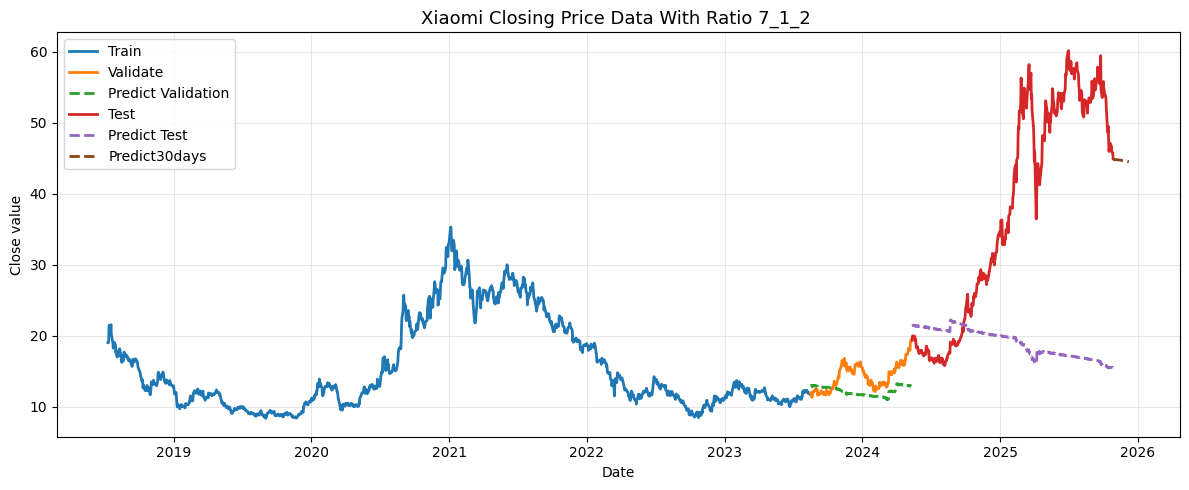

In [8]:
plt.figure(figsize=(12,5))
plt.plot(df_train['Date'], df_train['Close'], label='Train', color='tab:blue', linewidth=2)
plt.plot(df_val['Date'],   df_val['Close'],   label='Validate', color='tab:orange', linewidth=2)
plt.plot(df_test['Date'],  df_test['Close'],  label='Test', color='tab:red', linewidth=2)
plt.plot(df_val['Date'],  pred_val,   label='Predict Validation', color='tab:green', linewidth=2, linestyle='--')
plt.plot(df_test['Date'], pred_test,  label='Predict Test', color='tab:purple', linewidth=2, linestyle='--')
plt.plot(dates30,         pred30_prices, label='Predict30days', color='saddlebrown', linewidth=2, linestyle='--')
plt.title('Xiaomi Closing Price Data With Ratio 7_1_2 ', fontsize=13)
plt.xlabel('Date'); plt.ylabel('Close value')
plt.grid(True, alpha=0.3)
handles, labels = plt.gca().get_legend_handles_labels()
order = [0, 1, 3, 2, 4, 5]  # Train, Validate, Predict Validation, Test, Predict Test, Predict30days
plt.legend([handles[i] for i in order], [labels[i] for i in order], loc='upper left',frameon=True)
plt.tight_layout(); plt.show()
